![IonQ Logo](./IonQCV/logo.png)

# 👋 Welcome to IonQ's **Quantum Computer Vision** challenge, hosted by SCQ!
*by Willie Aboumrad, Vadim Karpusenko, and Heidi Nelson-Quillin*

Image classification is a key task in computer vision, with researchers continually improving models to achieve higher accuracy on standardized benchmarks. Recently, quantum computing methods have also been introduced as potential solutions, or part of these.

In this challenge, you'll take on the role of an IonQ Apps Team scientist, exploring image classification through quantum machine learning (QML) techniques.

<video controls src="./IonQCV/ion_trap_animation.mp4" width=90%; autoplay> </video>

We will tackle a binary classification problem, challenging you to design a hybrid classical-quantum neural network aimed at achieving the highest possible classification accuracy.

To assist you, we’ve provided exclusive access to unreleased features of IonQ’s next-generation SDK, which will handle the orchestration and the classical components of the hybrid pipeline. This allows you to concentrate on the most intriguing, purely quantum tasks:

- 🖼️ Encoding image data onto a quantum backend using an encoding circuit,
- ⚛️🧩 Differentiating encoded state vectors via a trainable ansatz, and
- 📊 Extracting relevant features for classification by measuring a set of observables.

Before you begin, remember to activate the "IonQ Vision Challenge" environment on the qBraid platform and switch to that kernel. If you encounter any issues at this stage, do not hesitate to ask for help.

![ENVS](./IonQCV/qBraid.png)

# 🕵️‍♂️ Your mission, should you choose to accept it

In this challenge, you'll build a hybrid quantum-classical image classification pipeline using <span style="color:purple">ionqvision</span>, IonQ’s next-generation platform for QML computations, along with [PyTorch](https://pytorch.org/). Specifically, you'll train a quantum-classical neural network to differentiate between two distinct types of handwritten digits from the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

<div class="alert alert-block alert-info">
<b>💡 Tip:</b> If you're new to <span style="color:purple">PyTorch</span>, no worries!

This challenge is all about the **quantum** in [Quantum Machine Learning](https://en.wikipedia.org/wiki/Quantum_machine_learning). The provided starter code takes care of all the setup, allowing you to concentrate on designing your best quantum circuits!</div>

The figure below showcases our hybrid pipeline, with the operations inside the gray box representing the quantum layer — where all the magic happens.

![hubrid neural network topology](./IonQCV/hybrid_nn.png)

*<p style="text-align: center;">Figure 1: A diagrammatic representation of our hybrid quantum-classical image classification pipeline</p>*

Your mission, should you choose to accept it, is to design the quantum layer that achieves **the highest possible classification accuracy**, which will be automatically scored on an unseen validation set. Sounds simple, right?

## 🎻 ⚛ 🎻 Classical, quantum, and then classical again

If you’ve made it thus far, congratulations! 🎉

You're about to embark on an exciting journey of quantum exploration. To start, we’ll dive into the architecture of our hybrid neural network. It's important to remember that running the full *hybrid* pipeline involves **both** classical and quantum hardware, along with software that enables communication between them. Fortunately, <span style="color:purple">ionqvision</span> simplifies much of this complexity, allowing you to focus on the quantum design.

In the following sections, we’ll break down the classical and quantum components of the pipeline in more detail. After that, we’ll guide you through the starter code so you can get up and running quickly!

### 🎹 Classical pre-processing

The initial three layers of our pipeline are purely classical and perform standard operations commonly found in classical image classification workflows. First, the input black and white with 1 byte per pixel image (single-channel) is flattened - meaning all raws of image combined in 1D array, then we apply dimensionality reduction using [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). Afterward, the compressed images are embedded into an even lower-dimensional feature space through a trainable fully-connected layer. During training, dropout is used, and the sigmoid [activation function](https://en.wikipedia.org/wiki/Activation_function) is applied.

![Classical pre-processing neural network](./IonQCV/classical_pre.png)

<div class="alert alert-block alert-warning"><span style="color:black">
<b>⚠️ Note:</b> <br>
This part of the architecture is essentially <b>fixed</b>: the only thing you get to decide here is the dimension 
<i>n</i> of the resulting latent vectors.<br> For instance, in <i>Figure 1</i>, <i>n = 12</i>.</span>
</div>

### ⚛️ Quantum Layer

Next comes the most exciting part: the "quantum layer." This is the heart of our challenge—your design here will determine the highest classification accuracy, and there's a big prize for achieving that! 🥇

The quantum layer is made up of three key components:

- An encoding circuit that loads each *n*-dimensional latent vector into an *n*-dimensional qubit state.
- A variational circuit with *n* qubits and trainable parameters, designed to learn how to separate encoded latent vectors within the high-dimensional multi-qubit state space.
- A set of *m* measurable quantities used to extract “quantum features” from the transformed *n*-qubit states for classification. (For example, in *Figure 1*, *m = 4*.)

![Quantum Layer](./IonQCV/quantum_layer.png)

To get started, explore the `ionqvision.ansatze.ansatz_library` module for inspiration. We've implemented several encoders and ansatze commonly used in the literature.

For example, you might try using the `AngleEncoder` for your initial model, which has the following structure.

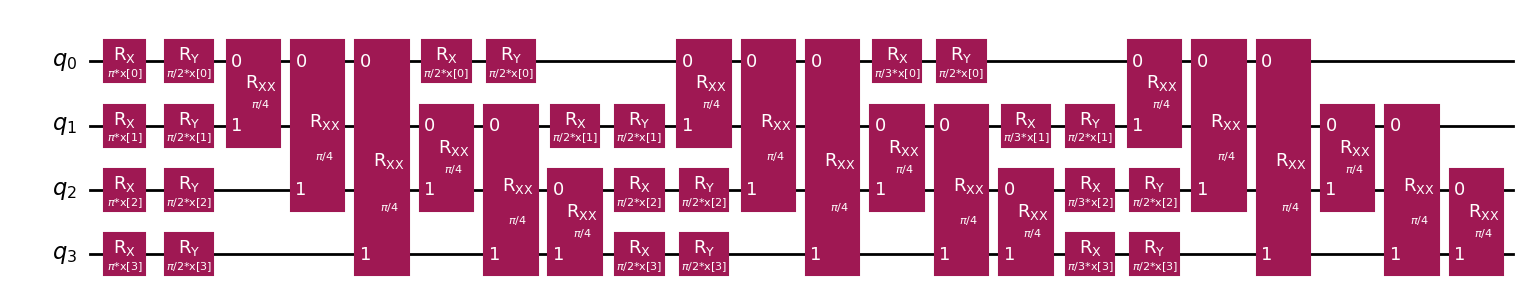

In [1]:
import ansatz_library_custom
from ansatz_library_custom import CustomEncoder

encoder = CustomEncoder(num_qubits=4)
encoder.draw("mpl")

To view the function's description (docstring), simply run the code cell `AngleEncoder?`. To examine its implementation, open the file `ionqvision/ansatze/ansatz_library` and find the `AngleEncoder` class.

Additionally, you can use its implementation as a template to create your own custom encoder designs!

In [2]:
AngleEncoder?

Object `AngleEncoder` not found.


Similarly, you can utilize built-in options like the `BrickworkLayoutAnsatz` or the `QCNNAnsatz`, among others, for the trainable layer.

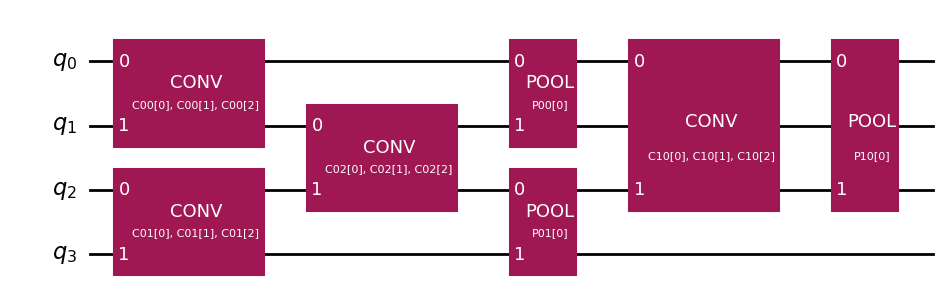

In [3]:
import ansatz_library_custom
from ansatz_library_custom import CustomAnsatz

ansatz = CustomAnsatz(num_qubits=4)
ansatz.draw("mpl")

This ansatz is particularly intriguing as it features a sequence of "convolution" filters, interspersed with pooling operations that reduce the number of "active" qubits with each layer. Note that our implementation modifies [the original design](https://www.nature.com/articles/s41567-019-0648-8) by replacing mid-circuit measurements with controlled rotations.

If you're interested in using this ansatz, be sure to [subclass](https://pybit.es/articles/python-subclasses/) and implement your own `QCNNAnsatz.ConvolutionBrickwork` and `QCNN.PoolingLayer` modules!

```python
class QCNNAnsatz(VariationalAnsatz):
    r"""
    Implement the Quantum Convolutional Network Ansatz (QCNN) as described in
    :cite:t:`2019:qcnn`.

    The quasi-local unitary $U_i$'s are entangling two-qubit gates with $6$
    variational parameters.
    They are laid out in a brickwork pattern with ``filter_depth`` layers.

    The pooling operations are implemented by two-qubit controlled rotations,
    with $2$ variational parameters.

    The circuit starts with ``num_qubits`` active qubits and then half the
    remaining qubits are discarded after each pooling operation until only a
    single active qubit remains. This final qubit is measured and the result is
    used for binary classification.
    """
    class ConvolutionBrickwork(BrickworkLayoutAnsatz):
        """
        Implement the convolution filters for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, num_layers, prefix=None, qubits=None, initial_state=None):
            super().__init__(num_qubits, num_layers, blk_sz=3, prefix=prefix, qubits=qubits, initial_state=initial_state)
        
        def two_qubit_block(self, theta, q1, q2):
            conv_op = QuantumCircuit(2, name="CONV")
            conv_op.ry(theta[0], 0)
            conv_op.ry(theta[1], 1)
            conv_op.rxx(theta[2], 0, 1)
            self.append(conv_op.to_instruction(), [q1, q2])

    class PoolingLayer(BrickworkLayoutAnsatz):
        """
        Implement the pooling layer for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, prefix=None, qubits=None):
            super().__init__(num_qubits, 1, blk_sz=1, prefix=prefix, qubits=qubits)
    
        def two_qubit_block(self, theta, q1, q2):
            pool_op = QuantumCircuit(2, name="POOL")
            pool_op.crz(theta[0], 1, 0)
            self.append(pool_op.to_instruction(), [q1, q2])

    def __init__(self, num_qubits, filter_depth=2, initial_state=None):
        num_layers = int(log(num_qubits, 2))
        if abs(log(num_qubits, 2) - num_layers) > 1e-6:
            raise ValueError("num_qubits must be a power of 2")

        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)

        for k in range(num_layers):
            qubits = list(range(0, num_qubits, 2**k))
        
            conv = QCNNAnsatz.ConvolutionBrickwork(num_qubits, filter_depth, prefix="C" + str(k), qubits=qubits)
            self.compose(conv, inplace=True)
            
            pool = QCNNAnsatz.PoolingLayer(num_qubits, prefix="P" + str(k), qubits=qubits)
            self.compose(pool, inplace=True)
```

Although <span style="color:purple">ionqvision</span> doesn’t offer built-in qubit observables, you can configure them using <span style="color:purple">Qiskit</span> with the following approach.

In [4]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
quantum_features = [
    SparsePauliOp(["IIIX"]), 
    SparsePauliOp(["IIIY"]), 
    SparsePauliOp(["IIIZ"])
]

Keep in mind that the encoder, ansatz, and quantum feature vector are closely interconnected: how you embed latent vectors into the (multi-)qubit state space should influence how you transform the encoded state vectors, which in turn should guide the features you choose to measure.

The most effective model will likely leverage synergies from the deliberate co-design of these three components.

<div class="alert alert-block alert-info">
<b>⚡️ Important</b> <br>
This is your chance to unleash your creativity! Think outside the box and show us what you can do. Don’t hesitate to tap into the vast resources available online and use everything at your disposal.
</div>

### 🎹 Classical post-processing

After the quantum layer, the feature vectors in the classification pipeline are transferred back to the classical device for post-processing. Specifically, we train a fully-connected layer with a scalar output to minimize the binary [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) between the final prediction and the true label of the input image. As before, dropout is applied during training, and the sigmoid [activation function](https://en.wikipedia.org/wiki/Activation_function) is used.

<p style="text-align: center;"><img src="./IonQCV/classical_post.png" alt="Classical post-processing" width="50%"/></p>

This final stage is intentionally light, to ensure the quantum layer is the star of the show.

<div class="alert alert-block alert-warning"><span style="color:black">
<b>⚠️ Note:</b> <br>
This part of the architecture is completely <b>fixed</b>: the input dimension <i>(m)</i> is determined by the quantum feature vector, and the output is always a scalar.</span>
</div>

## 🚂 Training your model

Once you've finalized your quantum layer, you can sit back and let <span style="color:purple">ionqvision</span> handle the heavy lifting. Start by setting up your classifier and ensuring everything functions as expected.

In [5]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features); classifier

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01025 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00858 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.06628 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.10085 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.00954 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.06413 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01049 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutationAnalysis - 0.39196 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.29802 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Collect2qBlocks - 0.08535 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 0.55146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.09561 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00978 (ms)
INFO:qiskit.passm

BinaryMNISTClassifier(
  (latent_vec_encoder): Sequential(
    (0): Linear(in_features=168, out_features=4, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (quantum_layer): QuantumModule()
  (prediction_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

By default, `qiskit` will print numerous `INFO` messages about passed tests. To suppress these messages, run the following code.

In [6]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

If you're wondering, `BinaryMNISTClassifier` is a standard `torch.nn.Module`. At this stage, all the parameters in your quantum layer have been registered with `Torch`, and autograd will automatically compute the necessary gradients during the backward pass. There's nothing else to worry about!

Make sure to check out the IonQ Vision Docs for more details on the inner workings of `BinaryMNISTClassifier` and related classes.

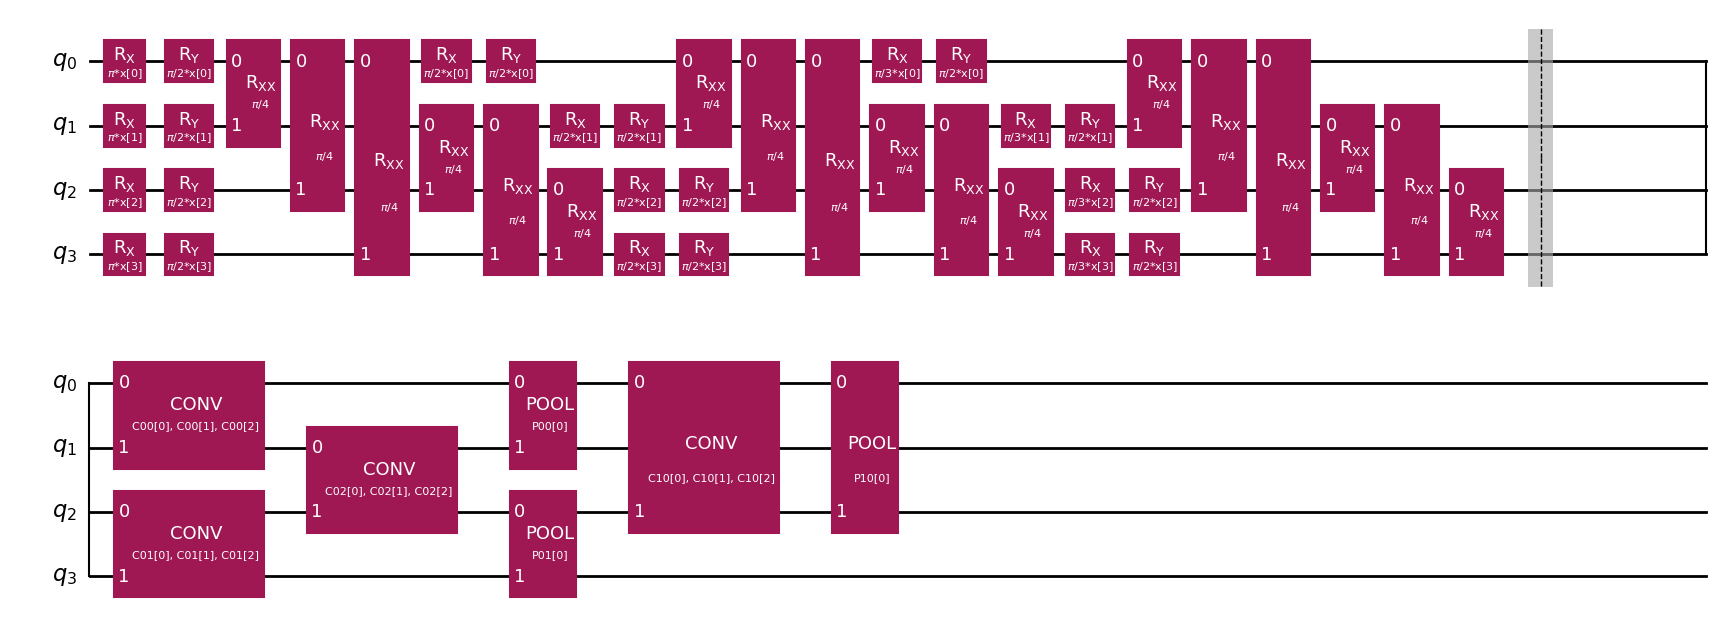

In [7]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

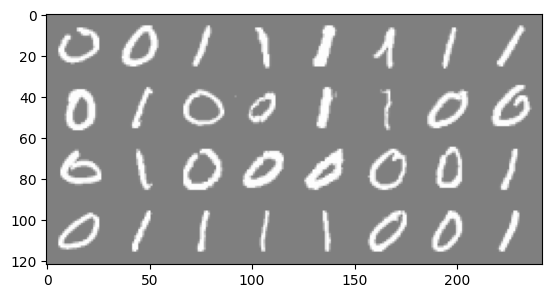

In [8]:
# Verify the images loaded correctly
classifier.visualize_batch()

Now train your model. Use the `config` dictionary to control lower-level aspects of the training, like the number of `epochs`, the learning rate `lr`, the `betas` used by [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), etc.

In [9]:
%%time
from torch.utils.data import random_split

# Get a (pre-processed) training/val and test set
train_val_set, test_set = classifier.get_train_test_set(train_size=400, test_size=100)
train_set, val_set = random_split(train_val_set, [300, 100])
train_set = train_set.dataset
val_set = val_set.dataset

# Configure model training hyper parameters
config = {
    "epochs": 4,
    "lr": 0.1,
    "batch_size": 50,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 6,
}

# Train and plot the results
classifier.train_module(train_set, val_set, config)

epoch:   1 | loss: 0.706
lr: 0.1000 | processed     6/    8 batches per epoch in 785.63s (1.85s forward / 124.10s backward)
Model achieved 56.500%  accuracy on TRAIN set.
Model achieved 56.500%  accuracy on TEST set.

epoch:   2 | loss: 0.694
lr: 0.1000 | processed     6/    8 batches per epoch in 757.28s (1.59s forward / 118.92s backward)
Model achieved 58.250%  accuracy on TRAIN set.
Model achieved 58.000%  accuracy on TEST set.

epoch:   3 | loss: 0.694
lr: 0.1000 | processed     6/    8 batches per epoch in 763.83s (2.41s forward / 121.86s backward)
Model achieved 55.000%  accuracy on TRAIN set.
Model achieved 53.750%  accuracy on TEST set.

epoch:   4 | loss: 0.696
lr: 0.1000 | processed     6/    8 batches per epoch in 757.26s (1.65s forward / 118.84s backward)
Model achieved 59.750%  accuracy on TRAIN set.
Model achieved 58.000%  accuracy on TEST set.

CPU times: user 1h 17min 42s, sys: 1min 11s, total: 1h 18min 53s
Wall time: 1h 7min 27s


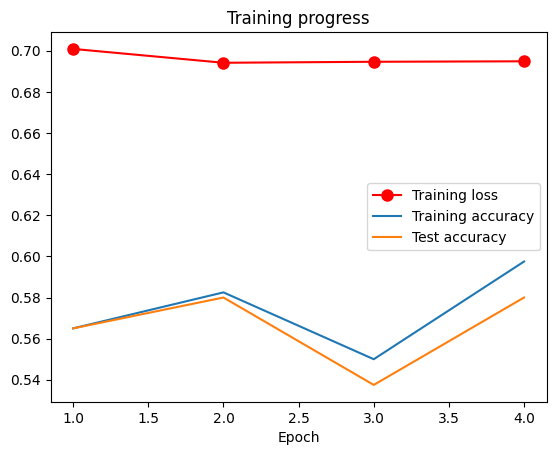

In [10]:
classifier.plot_training_progress()

## Evaluate Your Model
Now that your model is trained, it's time to test! 
Run your trained model on the testing set using the code below. 

In [34]:
# Evaluate the model on the test set
test_accuracy = classifier.compute_accuracy(test_set)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.58
